In [1]:
using Revise
using DifferentialEquations
using Flux
using DiffEqFlux
using Optim
using Plots
using FileIO
using JLD2
using OffsetArrays
using Kinetic

┌ Info: Precompiling Revise [295af30f-e4ad-537b-8983-00126c2a3abe]
└ @ Base loading.jl:1273
┌ Info: Precompiling DifferentialEquations [0c46a032-eb83-5123-abaf-570d42b7fbaa]
└ @ Base loading.jl:1273
┌ Info: Precompiling Flux [587475ba-b771-5e3f-ad9e-33799f191a9c]
└ @ Base loading.jl:1273
┌ Info: Precompiling DiffEqFlux [aae7a2af-3d4f-5e19-a356-7da93b79d9d0]
└ @ Base loading.jl:1273
┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1273
┌ Info: Precompiling JLD2 [033835bb-8acc-5ee8-8aae-3f567f8a3819]
└ @ Base loading.jl:1273
┌ Info: Precompiling Kinetic [82403725-3cee-4f7c-b214-1ce71af4a797]
└ @ Base loading.jl:1273


In [2]:
function bgk!(df, f, p, t)
    g, tau = p
    df .= (g .- f) ./ tau
end

bgk! (generic function with 1 method)

In [21]:
D = read_dict("../code/shock/shock1D.txt")
for key in keys(D)
    s = Symbol(key)
    @eval $s = $(D[key])
end

case = shock
space = 1d1f1v
nSpecies = 1
interpOrder = 1
limiter = vanleer
cfl = 0.95
maxTime = 250.0
x0 = -25.0
x1 = 25.0
nx = 50
pMeshType = uniform
nxg = 0
umin = -10.0
umax = 10.0
nu = 36
nug = 0
vMeshType = rectangle
knudsen = 1.0
mach = 2.0
prandtl = 1.0
inK = 0.0
omega = 0.5
alphaRef = 1.0
omegaRef = 0.5
tLen = 3
nh = 12



In [22]:
γ = 3.
set = Setup(case, space, nSpecies, interpOrder, limiter, cfl, maxTime)
pSpace = PSpace1D(x0, x1, nx, pMeshType, nxg)
μᵣ = ref_vhs_vis(knudsen, alphaRef, omegaRef)
gas = GasProperty(knudsen, mach, prandtl, inK, γ, omega, alphaRef, omegaRef, μᵣ)
vSpace = VSpace1D(umin, umax, nu, vMeshType, nug)
wL, primL, fL, bcL, wR, primR, fR, bcR = ib_rh(mach, γ, vSpace.u)
ib = IB1D1F(wL, primL, fL, bcL, wR, primR, fR, bcR)

ks = SolverSet(set, pSpace, vSpace, gas, ib, pwd());

In [208]:
ctr = OffsetArray{ControlVolume1D1F}(undef, eachindex(ks.pSpace.x))
face = Array{Interface1D1F}(undef, ks.pSpace.nx+1)
for i in eachindex(ctr)
    if i <= ks.pSpace.nx÷2
        ctr[i] = ControlVolume1D1F(ks.pSpace.x[i], ks.pSpace.dx[i], Float32.(ks.ib.wL), Float32.(ks.ib.primL), Float32.(ks.ib.fL))
    else
        ctr[i] = ControlVolume1D1F(ks.pSpace.x[i], ks.pSpace.dx[i], Float32.(ks.ib.wR), Float32.(ks.ib.primR), Float32.(ks.ib.fR))
    end
end
for i=1:ks.pSpace.nx+1
    face[i] = Interface1D1F(ks.ib.wL, ks.ib.fL)
end

In [209]:
sos = sound_speed(ks.ib.primR, γ)
vmax = ks.vSpace.u1 + sos
tmax = vmax / ks.pSpace.dx[1]
dt = Float32(ks.set.cfl / tmax)
tSpan = (0.f0, dt)
tRan = range(tSpan[1], tSpan[2], length=tLen)

0.0f0:0.03870998f0:0.07741996f0

In [211]:
residual = Array{Float32}(undef, 3)
for iter=1:1000
    Kinetic.evolve!(ks, ctr, face, dt)
    Kinetic.update!(ks, ctr, face, dt, residual)
end

In [212]:
X = Array{Float32}(undef, nu, nx);
for i in 1:nx
    X[:,i] .= ctr[i].f
end

In [213]:
M = Array{Float32}(undef, nu, nx)
τ = Array{Float32}(undef, 1, nx)
for i=1:nx
    M[:,i] .= maxwellian(ks.vSpace.u, ctr[i].prim)
    τ[1,i] = vhs_collision_time(ctr[i].prim, ks.gas.μᵣ, ks.gas.ω)
end

data_para = [M, τ];

In [214]:
prob = ODEProblem(bgk!, X, tSpan, data_para)
Y = solve(prob, Tsit5(), saveat=tRan) |> Array;

In [215]:
dudt = FastChain( (x, p) -> x.^2,
                   FastDense(vSpace.nu, vSpace.nu*16, tanh),
                   #FastDense(vSpace.nu*16, vSpace.nu*16, tanh),
                   FastDense(vSpace.nu*16, vSpace.nu) )
node = NeuralODE(dudt, tSpan, Tsit5(), saveat=tRan);

In [216]:
function loss_node(p) # without dataset
    diff = Array(node(X, p)) .- Y
    loss = sum(abs2, diff)
    return loss
end

loss_node (generic function with 1 method)

In [217]:
cb = function (p, l)
    display(l)
    return false
end

#19 (generic function with 1 method)

In [33]:
#res = DiffEqFlux.sciml_train(loss_node, node.p, ADAM(), dataset, cb=cb, maxiters=100)
res = DiffEqFlux.sciml_train(loss_node, node.p, ADAM(), cb=cb, maxiters=200)

2.2899375f0

loss: 2.29:   0%|▎                                        |  ETA: 0:26:02

1.5200129f0

loss: 1.52:   1%|▍                                        |  ETA: 0:14:49

1.4683578f0

loss: 1.47:   2%|▋                                        |  ETA: 0:11:14

1.4390385f0

loss: 1.44:   2%|▉                                        |  ETA: 0:09:16

1.3969768f0

loss: 1.4:   2%|█                                        |  ETA: 0:08:07

1.1843077f0

loss: 1.18:   3%|█▎                                       |  ETA: 0:07:28

1.0778198f0

loss: 1.08:   4%|█▍                                       |  ETA: 0:06:46

1.0661348f0

loss: 1.07:   4%|█▋                                       |  ETA: 0:06:22

1.0304452f0

loss: 1.03:   4%|█▉                                       |  ETA: 0:06:07

1.0063422f0

loss: 1.01:   5%|██                                       |  ETA: 0:05:52

0.9620857f0

loss: 0.962:   6%|██▎                                      |  ETA: 0:05:44

0.9039452f0

loss: 0.904:   6%|██▌                                      |  ETA: 0:05:33

0.8622341f0

loss: 0.862:   6%|██▋                                      |  ETA: 0:05:24

0.84640914f0

loss: 0.846:   7%|██▉                                      |  ETA: 0:05:15

0.8196398f0

loss: 0.82:   8%|███▏                                     |  ETA: 0:05:04

0.86399436f0

loss: 0.864:   8%|███▎                                     |  ETA: 0:04:54

0.8731111f0

loss: 0.873:   8%|███▌                                     |  ETA: 0:04:47

0.81295586f0

loss: 0.813:   9%|███▊                                     |  ETA: 0:04:44

0.74908453f0

loss: 0.749:  10%|███▉                                     |  ETA: 0:04:37

0.7216586f0

loss: 0.722:  10%|████▏                                    |  ETA: 0:04:31

0.7248695f0

loss: 0.725:  10%|████▎                                    |  ETA: 0:04:24

0.7321785f0

loss: 0.732:  11%|████▌                                    |  ETA: 0:04:19

0.71817493f0

loss: 0.718:  12%|████▊                                    |  ETA: 0:04:14

0.6642418f0

loss: 0.664:  12%|████▉                                    |  ETA: 0:04:10

0.64420533f0

loss: 0.644:  12%|█████▏                                   |  ETA: 0:04:05

0.6619997f0

loss: 0.662:  13%|█████▍                                   |  ETA: 0:04:01

0.6564271f0

loss: 0.656:  14%|█████▌                                   |  ETA: 0:03:59

0.6100143f0

loss: 0.61:  14%|█████▊                                   |  ETA: 0:03:55

0.5886382f0

loss: 0.589:  14%|██████                                   |  ETA: 0:03:52

0.6120976f0

loss: 0.612:  15%|██████▏                                  |  ETA: 0:03:50

0.59976727f0

loss: 0.6:  16%|██████▍                                  |  ETA: 0:03:46

0.59014475f0

loss: 0.59:  16%|██████▌                                  |  ETA: 0:03:43

0.6094946f0

loss: 0.609:  16%|██████▊                                  |  ETA: 0:03:40

0.60477257f0

loss: 0.605:  17%|███████                                  |  ETA: 0:03:37

0.5601058f0

loss: 0.56:  18%|███████▏                                 |  ETA: 0:03:34

0.5965012f0

loss: 0.597:  18%|███████▍                                 |  ETA: 0:03:33

0.59579974f0

loss: 0.596:  18%|███████▋                                 |  ETA: 0:03:31

0.5785385f0

loss: 0.579:  19%|███████▊                                 |  ETA: 0:03:29

0.5842124f0

loss: 0.584:  20%|████████                                 |  ETA: 0:03:27

0.59396946f0

loss: 0.594:  20%|████████▎                                |  ETA: 0:03:26

0.59360963f0

loss: 0.594:  20%|████████▍                                |  ETA: 0:03:24

0.574221f0

loss: 0.574:  21%|████████▋                                |  ETA: 0:03:21

0.57344705f0

loss: 0.573:  22%|████████▉                                |  ETA: 0:03:20

0.5598001f0

loss: 0.56:  22%|█████████                                |  ETA: 0:03:18

0.5697917f0

loss: 0.57:  22%|█████████▎                               |  ETA: 0:03:17

0.5710176f0

loss: 0.571:  23%|█████████▍                               |  ETA: 0:03:15

0.58242685f0

loss: 0.582:  24%|█████████▋                               |  ETA: 0:03:14

0.5705024f0

loss: 0.571:  24%|█████████▉                               |  ETA: 0:03:12

0.57480437f0

loss: 0.575:  24%|██████████                               |  ETA: 0:03:11

0.5783436f0

loss: 0.578:  25%|██████████▎                              |  ETA: 0:03:09

0.5753569f0

loss: 0.575:  26%|██████████▌                              |  ETA: 0:03:07

0.5471668f0

loss: 0.547:  26%|██████████▋                              |  ETA: 0:03:07

0.5444172f0

loss: 0.544:  26%|██████████▉                              |  ETA: 0:03:06

0.5784887f0

loss: 0.578:  27%|███████████▏                             |  ETA: 0:03:05

0.5426737f0

loss: 0.543:  28%|███████████▎                             |  ETA: 0:03:04

0.5300423f0

loss: 0.53:  28%|███████████▌                             |  ETA: 0:03:03

0.5447294f0

loss: 0.545:  28%|███████████▋                             |  ETA: 0:03:01

0.56988174f0

loss: 0.57:  29%|███████████▉                             |  ETA: 0:03:00

0.52796626f0

loss: 0.528:  30%|████████████▏                            |  ETA: 0:02:58

0.53013134f0

loss: 0.53:  30%|████████████▎                            |  ETA: 0:02:56

0.5322738f0

loss: 0.532:  30%|████████████▌                            |  ETA: 0:02:55

0.5486023f0

loss: 0.549:  31%|████████████▊                            |  ETA: 0:02:53

0.56375617f0

loss: 0.564:  32%|████████████▉                            |  ETA: 0:02:51

0.5498135f0

loss: 0.55:  32%|█████████████▏                           |  ETA: 0:02:50

0.52906734f0

loss: 0.529:  32%|█████████████▍                           |  ETA: 0:02:48

0.5351287f0

loss: 0.535:  33%|█████████████▌                           |  ETA: 0:02:47

0.55332273f0

loss: 0.553:  34%|█████████████▊                           |  ETA: 0:02:46

0.5135184f0

loss: 0.514:  34%|██████████████                           |  ETA: 0:02:44

0.51502526f0

loss: 0.515:  34%|██████████████▏                          |  ETA: 0:02:43

0.52163434f0

loss: 0.522:  35%|██████████████▍                          |  ETA: 0:02:42

0.5308182f0

loss: 0.531:  36%|██████████████▌                          |  ETA: 0:02:41

0.515435f0

loss: 0.515:  36%|██████████████▊                          |  ETA: 0:02:39

0.485996f0

loss: 0.486:  36%|███████████████                          |  ETA: 0:02:38

0.4991287f0

loss: 0.499:  37%|███████████████▏                         |  ETA: 0:02:36

0.51265395f0

loss: 0.513:  38%|███████████████▍                         |  ETA: 0:02:35

0.5233039f0

loss: 0.523:  38%|███████████████▋                         |  ETA: 0:02:34

0.52028745f0

loss: 0.52:  38%|███████████████▊                         |  ETA: 0:02:33

0.477175f0

loss: 0.477:  39%|████████████████                         |  ETA: 0:02:32

0.4994513f0

loss: 0.499:  40%|████████████████▎                        |  ETA: 0:02:31

0.5160988f0

loss: 0.516:  40%|████████████████▍                        |  ETA: 0:02:30

0.50411904f0

loss: 0.504:  40%|████████████████▋                        |  ETA: 0:02:28

0.4773127f0

loss: 0.477:  41%|████████████████▊                        |  ETA: 0:02:27

0.49895456f0

loss: 0.499:  42%|█████████████████                        |  ETA: 0:02:26

0.5251322f0

loss: 0.525:  42%|█████████████████▎                       |  ETA: 0:02:25

0.5005872f0

loss: 0.501:  42%|█████████████████▍                       |  ETA: 0:02:24

0.48042688f0

loss: 0.48:  43%|█████████████████▋                       |  ETA: 0:02:22

0.49811664f0

loss: 0.498:  44%|█████████████████▉                       |  ETA: 0:02:21

0.48945507f0

loss: 0.489:  44%|██████████████████                       |  ETA: 0:02:20

0.49727118f0

loss: 0.497:  44%|██████████████████▎                      |  ETA: 0:02:19

0.48648202f0

loss: 0.486:  45%|██████████████████▌                      |  ETA: 0:02:17

0.4929165f0

loss: 0.493:  46%|██████████████████▋                      |  ETA: 0:02:16

0.473395f0

loss: 0.473:  46%|██████████████████▉                      |  ETA: 0:02:15

0.45713142f0

loss: 0.457:  46%|███████████████████▏                     |  ETA: 0:02:13

0.48802516f0

loss: 0.488:  47%|███████████████████▎                     |  ETA: 0:02:12

0.45692268f0

loss: 0.457:  48%|███████████████████▌                     |  ETA: 0:02:11

0.48794737f0

loss: 0.488:  48%|███████████████████▋                     |  ETA: 0:02:10

0.48701584f0

loss: 0.487:  48%|███████████████████▉                     |  ETA: 0:02:09

0.48373872f0

loss: 0.484:  49%|████████████████████▏                    |  ETA: 0:02:07

0.47993594f0

loss: 0.48:  50%|████████████████████▎                    |  ETA: 0:02:06

0.49054605f0

loss: 0.491:  50%|████████████████████▌                    |  ETA: 0:02:04

0.46669304f0

loss: 0.467:  50%|████████████████████▊                    |  ETA: 0:02:03

0.47111174f0

loss: 0.471:  51%|████████████████████▉                    |  ETA: 0:02:02

0.49438134f0

loss: 0.494:  52%|█████████████████████▏                   |  ETA: 0:02:01

0.4630954f0

loss: 0.463:  52%|█████████████████████▍                   |  ETA: 0:01:59

0.48568416f0

loss: 0.486:  52%|█████████████████████▌                   |  ETA: 0:01:58

0.5083933f0

loss: 0.508:  53%|█████████████████████▊                   |  ETA: 0:01:57

0.4994286f0

loss: 0.499:  54%|█████████████████████▉                   |  ETA: 0:01:56

0.4734326f0

loss: 0.473:  54%|██████████████████████▏                  |  ETA: 0:01:55

0.47638464f0

loss: 0.476:  54%|██████████████████████▍                  |  ETA: 0:01:53

0.4747966f0

loss: 0.475:  55%|██████████████████████▌                  |  ETA: 0:01:53

0.47307646f0

loss: 0.473:  56%|██████████████████████▊                  |  ETA: 0:01:51

0.4793697f0

loss: 0.479:  56%|███████████████████████                  |  ETA: 0:01:50

0.48096845f0

loss: 0.481:  56%|███████████████████████▏                 |  ETA: 0:01:49

0.47730052f0

loss: 0.477:  57%|███████████████████████▍                 |  ETA: 0:01:47

0.4578033f0

loss: 0.458:  58%|███████████████████████▋                 |  ETA: 0:01:46

0.47608668f0

loss: 0.476:  58%|███████████████████████▊                 |  ETA: 0:01:45

0.45769355f0

loss: 0.458:  58%|████████████████████████                 |  ETA: 0:01:44

0.4466381f0

loss: 0.447:  59%|████████████████████████▎                |  ETA: 0:01:42

0.43849367f0

loss: 0.438:  60%|████████████████████████▍                |  ETA: 0:01:41

0.45885664f0

loss: 0.459:  60%|████████████████████████▋                |  ETA: 0:01:40

0.43548667f0

loss: 0.435:  60%|████████████████████████▊                |  ETA: 0:01:39

0.44929233f0

loss: 0.449:  61%|█████████████████████████                |  ETA: 0:01:38

0.46814182f0

loss: 0.468:  62%|█████████████████████████▎               |  ETA: 0:01:36

0.46933708f0

loss: 0.469:  62%|█████████████████████████▍               |  ETA: 0:01:35

0.4418359f0

loss: 0.442:  62%|█████████████████████████▋               |  ETA: 0:01:34

0.4490617f0

loss: 0.449:  63%|█████████████████████████▉               |  ETA: 0:01:32

0.44527957f0

loss: 0.445:  64%|██████████████████████████               |  ETA: 0:01:31

0.4359082f0

loss: 0.436:  64%|██████████████████████████▎              |  ETA: 0:01:30

0.4718647f0

loss: 0.472:  64%|██████████████████████████▌              |  ETA: 0:01:29

0.46762002f0

loss: 0.468:  65%|██████████████████████████▋              |  ETA: 0:01:27

0.4550748f0

loss: 0.455:  66%|██████████████████████████▉              |  ETA: 0:01:26

0.46320435f0

loss: 0.463:  66%|███████████████████████████              |  ETA: 0:01:25

0.47344694f0

loss: 0.473:  66%|███████████████████████████▎             |  ETA: 0:01:24

0.4722941f0

loss: 0.472:  67%|███████████████████████████▌             |  ETA: 0:01:22

0.46756315f0

loss: 0.468:  68%|███████████████████████████▋             |  ETA: 0:01:21

0.48159638f0

loss: 0.482:  68%|███████████████████████████▉             |  ETA: 0:01:20

0.45367068f0

loss: 0.454:  68%|████████████████████████████▏            |  ETA: 0:01:19

0.46154058f0

loss: 0.462:  69%|████████████████████████████▎            |  ETA: 0:01:17

0.47786078f0

loss: 0.478:  70%|████████████████████████████▌            |  ETA: 0:01:16

0.4570156f0

loss: 0.457:  70%|████████████████████████████▊            |  ETA: 0:01:15

0.45876437f0

loss: 0.459:  70%|████████████████████████████▉            |  ETA: 0:01:13

0.4574905f0

loss: 0.457:  71%|█████████████████████████████▏           |  ETA: 0:01:12

0.4757354f0

loss: 0.476:  72%|█████████████████████████████▍           |  ETA: 0:01:11

0.4544651f0

loss: 0.454:  72%|█████████████████████████████▌           |  ETA: 0:01:10

0.45192564f0

loss: 0.452:  72%|█████████████████████████████▊           |  ETA: 0:01:09

0.4385221f0

loss: 0.439:  73%|█████████████████████████████▉           |  ETA: 0:01:07

0.42985272f0

loss: 0.43:  74%|██████████████████████████████▏          |  ETA: 0:01:06

0.45573166f0

loss: 0.456:  74%|██████████████████████████████▍          |  ETA: 0:01:05

0.4644472f0

loss: 0.464:  74%|██████████████████████████████▌          |  ETA: 0:01:04

0.4733383f0

loss: 0.473:  75%|██████████████████████████████▊          |  ETA: 0:01:03

0.44153747f0

loss: 0.442:  76%|███████████████████████████████          |  ETA: 0:01:01

0.47246906f0

loss: 0.472:  76%|███████████████████████████████▏         |  ETA: 0:01:00

0.44719127f0

loss: 0.447:  76%|███████████████████████████████▍         |  ETA: 0:00:59

0.4365623f0

loss: 0.437:  77%|███████████████████████████████▋         |  ETA: 0:00:57

0.44899052f0

loss: 0.449:  78%|███████████████████████████████▊         |  ETA: 0:00:56

0.43043026f0

loss: 0.43:  78%|████████████████████████████████         |  ETA: 0:00:55

0.43088046f0

loss: 0.431:  78%|████████████████████████████████▏        |  ETA: 0:00:54

0.42754328f0

loss: 0.428:  79%|████████████████████████████████▍        |  ETA: 0:00:53

0.42170113f0

loss: 0.422:  80%|████████████████████████████████▋        |  ETA: 0:00:51

0.40521225f0

loss: 0.405:  80%|████████████████████████████████▊        |  ETA: 0:00:50

0.4241571f0

loss: 0.424:  80%|█████████████████████████████████        |  ETA: 0:00:49

0.44436094f0

loss: 0.444:  81%|█████████████████████████████████▎       |  ETA: 0:00:48

0.43915266f0

loss: 0.439:  82%|█████████████████████████████████▍       |  ETA: 0:00:46

0.4110247f0

loss: 0.411:  82%|█████████████████████████████████▋       |  ETA: 0:00:45

0.42071956f0

loss: 0.421:  82%|█████████████████████████████████▉       |  ETA: 0:00:44

0.4287842f0

loss: 0.429:  83%|██████████████████████████████████       |  ETA: 0:00:43

0.41372758f0

loss: 0.414:  84%|██████████████████████████████████▎      |  ETA: 0:00:41

0.41207942f0

loss: 0.412:  84%|██████████████████████████████████▌      |  ETA: 0:00:40

0.4092026f0

loss: 0.409:  84%|██████████████████████████████████▋      |  ETA: 0:00:39

0.42513838f0

loss: 0.425:  85%|██████████████████████████████████▉      |  ETA: 0:00:38

0.4353638f0

loss: 0.435:  86%|███████████████████████████████████      |  ETA: 0:00:36

0.42673486f0

loss: 0.427:  86%|███████████████████████████████████▎     |  ETA: 0:00:35

0.39329514f0

loss: 0.393:  86%|███████████████████████████████████▌     |  ETA: 0:00:34

0.4267088f0

loss: 0.427:  87%|███████████████████████████████████▋     |  ETA: 0:00:33

0.41147235f0

loss: 0.411:  88%|███████████████████████████████████▉     |  ETA: 0:00:31

0.39352578f0

loss: 0.394:  88%|████████████████████████████████████▏    |  ETA: 0:00:30

0.4191176f0

loss: 0.419:  88%|████████████████████████████████████▎    |  ETA: 0:00:29

0.43057418f0

loss: 0.431:  89%|████████████████████████████████████▌    |  ETA: 0:00:28

0.40772343f0

loss: 0.408:  90%|████████████████████████████████████▊    |  ETA: 0:00:26

0.3821067f0

loss: 0.382:  90%|████████████████████████████████████▉    |  ETA: 0:00:25

0.41864264f0

loss: 0.419:  90%|█████████████████████████████████████▏   |  ETA: 0:00:24

0.4107924f0

loss: 0.411:  91%|█████████████████████████████████████▎   |  ETA: 0:00:23

0.3834707f0

loss: 0.383:  92%|█████████████████████████████████████▌   |  ETA: 0:00:21

0.4203574f0

loss: 0.42:  92%|█████████████████████████████████████▊   |  ETA: 0:00:20

0.42975122f0

loss: 0.43:  92%|█████████████████████████████████████▉   |  ETA: 0:00:19

0.4350369f0

loss: 0.435:  93%|██████████████████████████████████████▏  |  ETA: 0:00:18

0.4165342f0

loss: 0.417:  94%|██████████████████████████████████████▍  |  ETA: 0:00:16

0.4201778f0

loss: 0.42:  94%|██████████████████████████████████████▌  |  ETA: 0:00:15

0.41678327f0

loss: 0.417:  94%|██████████████████████████████████████▊  |  ETA: 0:00:14

0.40678102f0

loss: 0.407:  95%|███████████████████████████████████████  |  ETA: 0:00:13

0.42619315f0

loss: 0.426:  96%|███████████████████████████████████████▏ |  ETA: 0:00:11

0.4476899f0

loss: 0.448:  96%|███████████████████████████████████████▍ |  ETA: 0:00:10

0.45957032f0

loss: 0.46:  96%|███████████████████████████████████████▋ |  ETA: 0:00:09

0.41688108f0

loss: 0.417:  97%|███████████████████████████████████████▊ |  ETA: 0:00:08

0.40917018f0

loss: 0.409:  98%|████████████████████████████████████████ |  ETA: 0:00:06

0.4384711f0

loss: 0.438:  98%|████████████████████████████████████████▏|  ETA: 0:00:05

0.4302708f0

loss: 0.43:  98%|████████████████████████████████████████▍|  ETA: 0:00:04

0.40266702f0

loss: 0.403:  99%|████████████████████████████████████████▋|  ETA: 0:00:03

0.43421742f0

loss: 0.434: 100%|████████████████████████████████████████▊|  ETA: 0:00:01

0.45816734f0

loss: 0.458: 100%|█████████████████████████████████████████| Time: 0:04:10


0.3821067f0

 * Status: failure (reached maximum number of iterations)

 * Candidate solution
    Minimizer: [-4.69e-02, 7.89e-02, -2.35e-02,  ...]
    Minimum:   4.581673e-01

 * Found with
    Algorithm:     ADAM
    Initial Point: [-4.68e-02, 7.89e-02, -2.35e-02,  ...]

 * Convergence measures
    |x - x'|               = NaN ≰ 0.0e+00
    |x - x'|/|x'|          = NaN ≰ 0.0e+00
    |f(x) - f(x')|         = NaN ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = NaN ≰ 0.0e+00
    |g(x)|                 = NaN ≰ 0.0e+00

 * Work counters
    Seconds run:   251  (vs limit Inf)
    Iterations:    200
    f(x) calls:    200
    ∇f(x) calls:   200


In [158]:
#res = DiffEqFlux.sciml_train(loss_node, res.minimizer, ADAM(), dataset, cb=Flux.throttle(cb, 1), maxiters=1000)
res = DiffEqFlux.sciml_train(loss_node, res.minimizer, ADAM(), cb=Flux.throttle(cb, 1), maxiters=400)

6.947397f0

loss: 5.1:   0%|▎                                        |  ETA: 0:34:23m

3.8722093f0

loss: 3.22:   1%|▍                                        |  ETA: 0:21:15

3.170754f0

loss: 3.26:   2%|▋                                        |  ETA: 0:17:11

3.048909f0

loss: 2.6:   2%|▉                                        |  ETA: 0:15:11m

2.3492167f0

loss: 2.09:   2%|█                                        |  ETA: 0:13:54

1.7699149f0

loss: 1.63:   3%|█▎                                       |  ETA: 0:13:09

1.5426803f0

loss: 1.45:   4%|█▍                                       |  ETA: 0:12:29

1.3658637f0

loss: 1.31:   4%|█▋                                       |  ETA: 0:11:58

1.1367986f0

loss: 0.851:   4%|█▉                                       |  ETA: 0:11:35

0.8276946f0

loss: 0.945:   5%|██                                       |  ETA: 0:11:08

0.9953926f0

loss: 1.04:   6%|██▎                                      |  ETA: 0:10:52m

1.0111159f0

loss: 0.909:   6%|██▌                                      |  ETA: 0:10:34

0.8483271f0

loss: 0.813:   6%|██▋                                      |  ETA: 0:10:26

0.7374777f0

loss: 0.651:   7%|██▉                                      |  ETA: 0:10:09

0.5765276f0

loss: 0.615:   8%|███▏                                     |  ETA: 0:09:58

0.5536214f0

loss: 0.543:   8%|███▎                                     |  ETA: 0:09:49

0.6087866f0

loss: 0.607:   8%|███▌                                     |  ETA: 0:09:41

0.54719275f0

loss: 0.497:   9%|███▊                                     |  ETA: 0:09:32

0.49648258f0

loss: 0.459:  10%|███▉                                     |  ETA: 0:09:30

0.40943378f0

loss: 0.417:  10%|████▏                                    |  ETA: 0:09:24

0.4409938f0

loss: 0.455:  10%|████▎                                    |  ETA: 0:09:16

0.40113837f0

loss: 0.386:  11%|████▌                                    |  ETA: 0:09:07

0.38787982f0

loss: 0.384:  12%|████▊                                    |  ETA: 0:08:59

0.4333429f0

loss: 0.403:  12%|████▉                                    |  ETA: 0:08:51

0.33057463f0

loss: 0.386:  12%|█████▏                                   |  ETA: 0:08:43

0.41279897f0

loss: 0.328:  13%|█████▍                                   |  ETA: 0:08:35

0.33391726f0

loss: 0.321:  14%|█████▊                                   |  ETA: 0:08:22

0.33224878f0

loss: 0.332:  14%|██████                                   |  ETA: 0:08:15

0.31760967f0

loss: 0.353:  15%|██████▏                                  |  ETA: 0:08:09

0.35767063f0

loss: 0.342:  16%|██████▍                                  |  ETA: 0:08:05

0.3023101f0

loss: 0.311:  16%|██████▌                                  |  ETA: 0:08:00

0.35905308f0

loss: 0.338:  16%|██████▊                                  |  ETA: 0:07:55

0.3134349f0

loss: 0.31:  17%|███████                                  |  ETA: 0:07:51m

0.30736643f0

loss: 0.36:  18%|███████▏                                 |  ETA: 0:07:48m

0.28677034f0

loss: 0.372:  18%|███████▍                                 |  ETA: 0:07:44

0.34990832f0

loss: 0.316:  18%|███████▋                                 |  ETA: 0:07:40

0.33498567f0

loss: 0.286:  19%|███████▊                                 |  ETA: 0:07:38

0.31928322f0

loss: 0.323:  20%|████████                                 |  ETA: 0:07:34

0.30050802f0

loss: 0.359:  20%|████████▎                                |  ETA: 0:07:30

0.3086906f0

loss: 0.343:  20%|████████▍                                |  ETA: 0:07:27

0.33978072f0

loss: 0.291:  21%|████████▋                                |  ETA: 0:07:22

0.33343688f0

loss: 0.309:  22%|████████▉                                |  ETA: 0:07:19

0.3108423f0

loss: 0.293:  22%|█████████                                |  ETA: 0:07:16

0.3123893f0

loss: 0.309:  22%|█████████▎                               |  ETA: 0:07:13

0.29737148f0

loss: 0.277:  23%|█████████▍                               |  ETA: 0:07:09

0.29024988f0

loss: 0.307:  24%|█████████▋                               |  ETA: 0:07:06

0.27406108f0

loss: 0.325:  24%|█████████▉                               |  ETA: 0:07:02

0.33548537f0

loss: 0.343:  24%|██████████                               |  ETA: 0:06:59

0.29179993f0

loss: 0.338:  25%|██████████▎                              |  ETA: 0:06:54

0.29929352f0

loss: 0.329:  26%|██████████▌                              |  ETA: 0:06:50

0.29738244f0

loss: 0.294:  26%|██████████▋                              |  ETA: 0:06:49

0.31047866f0

loss: 0.288:  26%|██████████▉                              |  ETA: 0:06:46

0.28201693f0

loss: 0.257:  27%|███████████▏                             |  ETA: 0:06:42

0.27893877f0

loss: 0.287:  28%|███████████▎                             |  ETA: 0:06:39

0.2616891f0

loss: 0.289:  28%|███████████▌                             |  ETA: 0:06:36

0.31003982f0

loss: 0.269:  28%|███████████▋                             |  ETA: 0:06:33

0.281905f0

loss: 0.282:  29%|███████████▉                             |  ETA: 0:06:30

0.26078522f0

loss: 0.265:  30%|████████████▏                            |  ETA: 0:06:26

0.24991211f0

loss: 0.28:  30%|████████████▎                            |  ETA: 0:06:23

0.2915981f0

loss: 0.27:  30%|████████████▌                            |  ETA: 0:06:20m

0.25010115f0

loss: 0.268:  31%|████████████▊                            |  ETA: 0:06:16

0.25171822f0

loss: 0.259:  32%|████████████▉                            |  ETA: 0:06:13

0.2972566f0

loss: 0.297:  32%|█████████████▏                           |  ETA: 0:06:09

0.27719265f0

loss: 0.271:  32%|█████████████▍                           |  ETA: 0:06:06

0.29343468f0

loss: 0.325:  33%|█████████████▌                           |  ETA: 0:06:03

0.31980065f0

loss: 0.354:  34%|█████████████▊                           |  ETA: 0:06:01

0.31085175f0

loss: 0.279:  34%|██████████████                           |  ETA: 0:05:58

0.31872326f0

loss: 0.321:  34%|██████████████▏                          |  ETA: 0:05:56

0.27454597f0

loss: 0.295:  35%|██████████████▍                          |  ETA: 0:05:53

0.3132395f0

loss: 0.295:  36%|██████████████▋                          |  ETA: 0:05:49

0.2708866f0

loss: 0.311:  36%|██████████████▉                          |  ETA: 0:05:45

0.3094378f0

loss: 0.275:  37%|███████████████                          |  ETA: 0:05:42

0.3068648f0

loss: 0.294:  37%|███████████████▎                         |  ETA: 0:05:39

0.2952526f0

loss: 0.313:  38%|███████████████▋                         |  ETA: 0:05:33

0.29303414f0

loss: 0.288:  38%|███████████████▊                         |  ETA: 0:05:30

0.30700964f0

loss: 0.297:  39%|████████████████                         |  ETA: 0:05:27

0.31200668f0

loss: 0.296:  40%|████████████████▎                        |  ETA: 0:05:25

0.30292368f0

loss: 0.32:  40%|████████████████▍                        |  ETA: 0:05:22m

0.27410737f0

loss: 0.264:  40%|████████████████▋                        |  ETA: 0:05:20

0.2933251f0

loss: 0.27:  41%|████████████████▊                        |  ETA: 0:05:16m

0.27382785f0

loss: 0.279:  42%|█████████████████                        |  ETA: 0:05:14

0.2843734f0

loss: 0.327:  42%|█████████████████▎                       |  ETA: 0:05:12

0.31272578f0

loss: 0.288:  42%|█████████████████▍                       |  ETA: 0:05:09

0.29552317f0

loss: 0.297:  43%|█████████████████▋                       |  ETA: 0:05:06

0.32867938f0

loss: 0.308:  44%|█████████████████▉                       |  ETA: 0:05:03

0.3398861f0

loss: 0.295:  44%|██████████████████                       |  ETA: 0:05:00

0.35336655f0

loss: 0.309:  44%|██████████████████▎                      |  ETA: 0:04:59

0.37073112f0

loss: 0.369:  45%|██████████████████▌                      |  ETA: 0:04:56

0.32636693f0

loss: 0.328:  46%|██████████████████▋                      |  ETA: 0:04:54

0.34526762f0

loss: 0.353:  46%|██████████████████▉                      |  ETA: 0:04:51

0.28513923f0

loss: 0.339:  46%|███████████████████▏                     |  ETA: 0:04:48

0.31449482f0

loss: 0.32:  47%|███████████████████▎                     |  ETA: 0:04:45m

0.29050288f0

loss: 0.325:  48%|███████████████████▌                     |  ETA: 0:04:42

0.29658f0

loss: 0.296:  48%|███████████████████▋                     |  ETA: 0:04:39

0.2656078f0

loss: 0.322:  48%|███████████████████▉                     |  ETA: 0:04:36

0.32288608f0

loss: 0.289:  49%|████████████████████▏                    |  ETA: 0:04:33

0.33361515f0

loss: 0.307:  50%|████████████████████▎                    |  ETA: 0:04:31

0.24859208f0

loss: 0.295:  50%|████████████████████▌                    |  ETA: 0:04:27

0.30426547f0

loss: 0.294:  50%|████████████████████▊                    |  ETA: 0:04:25

0.303321f0

loss: 0.305:  51%|████████████████████▉                    |  ETA: 0:04:22

0.3089534f0

loss: 0.3:  52%|█████████████████████▏                   |  ETA: 0:04:199m

0.33775955f0

loss: 0.3:  52%|█████████████████████▍                   |  ETA: 0:04:179m

0.31304985f0

loss: 0.338:  52%|█████████████████████▌                   |  ETA: 0:04:14

0.30868703f0

loss: 0.337:  53%|█████████████████████▊                   |  ETA: 0:04:11

0.32247674f0

loss: 0.33:  54%|█████████████████████▉                   |  ETA: 0:04:09m

0.28567508f0

loss: 0.302:  54%|██████████████████████▏                  |  ETA: 0:04:06

0.30142036f0

loss: 0.279:  54%|██████████████████████▍                  |  ETA: 0:04:03

0.24619249f0

loss: 0.267:  55%|██████████████████████▌                  |  ETA: 0:04:00

0.3069125f0

loss: 0.259:  56%|██████████████████████▉                  |  ETA: 0:03:56

0.25506407f0

loss: 0.306:  56%|███████████████████████▏                 |  ETA: 0:03:52

0.26626006f0

loss: 0.276:  57%|███████████████████████▍                 |  ETA: 0:03:49

0.29753542f0

loss: 0.283:  58%|███████████████████████▋                 |  ETA: 0:03:46

0.25775355f0

loss: 0.268:  58%|███████████████████████▊                 |  ETA: 0:03:43

0.277458f0

loss: 0.289:  58%|████████████████████████                 |  ETA: 0:03:40

0.27617228f0

loss: 0.274:  59%|████████████████████████▎                |  ETA: 0:03:36

0.30293787f0

loss: 0.246:  60%|████████████████████████▋                |  ETA: 0:03:32

0.28544733f0

loss: 0.249:  61%|████████████████████████▉                |  ETA: 0:03:28

0.26599014f0

loss: 0.289:  61%|█████████████████████████▏               |  ETA: 0:03:25

0.30366975f0

loss: 0.262:  62%|█████████████████████████▍               |  ETA: 0:03:20

0.2697288f0

loss: 0.274:  62%|█████████████████████████▋               |  ETA: 0:03:18

0.27152586f0

loss: 0.284:  63%|█████████████████████████▉               |  ETA: 0:03:15

0.2661202f0

loss: 0.306:  64%|██████████████████████████               |  ETA: 0:03:12

0.30635244f0

loss: 0.287:  64%|██████████████████████████▎              |  ETA: 0:03:09

0.2722914f0

loss: 0.271:  64%|██████████████████████████▌              |  ETA: 0:03:07

0.27848503f0

loss: 0.303:  65%|██████████████████████████▋              |  ETA: 0:03:04

0.2858426f0

loss: 0.311:  66%|██████████████████████████▉              |  ETA: 0:03:01

0.3156957f0

loss: 0.291:  66%|███████████████████████████              |  ETA: 0:02:59

0.3021489f0

loss: 0.324:  66%|███████████████████████████▎             |  ETA: 0:02:56

0.32523698f0

loss: 0.309:  67%|███████████████████████████▌             |  ETA: 0:02:53

0.26714683f0

loss: 0.279:  68%|███████████████████████████▋             |  ETA: 0:02:51

0.30085322f0

loss: 0.271:  68%|███████████████████████████▉             |  ETA: 0:02:48

0.28677717f0

loss: 0.285:  68%|████████████████████████████▏            |  ETA: 0:02:45

0.27582383f0

loss: 0.325:  69%|████████████████████████████▎            |  ETA: 0:02:42

0.3048806f0

loss: 0.311:  70%|████████████████████████████▌            |  ETA: 0:02:40

0.29378855f0

loss: 0.309:  70%|████████████████████████████▊            |  ETA: 0:02:37

0.29082638f0

loss: 0.275:  70%|████████████████████████████▉            |  ETA: 0:02:35

0.30446917f0

loss: 0.305:  71%|█████████████████████████████▏           |  ETA: 0:02:32

0.28955346f0

loss: 0.298:  72%|█████████████████████████████▍           |  ETA: 0:02:29

0.30696028f0

loss: 0.312:  72%|█████████████████████████████▌           |  ETA: 0:02:27

0.25950164f0

loss: 0.261:  72%|█████████████████████████████▊           |  ETA: 0:02:24

0.29475158f0

loss: 0.289:  73%|█████████████████████████████▉           |  ETA: 0:02:21

0.27277488f0

loss: 0.278:  74%|██████████████████████████████▏          |  ETA: 0:02:19

0.26108533f0

loss: 0.276:  74%|██████████████████████████████▍          |  ETA: 0:02:16

0.2917074f0

loss: 0.272:  74%|██████████████████████████████▌          |  ETA: 0:02:14

0.31367993f0

loss: 0.333:  75%|██████████████████████████████▊          |  ETA: 0:02:11

0.2849202f0

loss: 0.324:  76%|███████████████████████████████          |  ETA: 0:02:08

0.30202985f0

loss: 0.291:  76%|███████████████████████████████▏         |  ETA: 0:02:06

0.2880144f0

loss: 0.312:  76%|███████████████████████████████▍         |  ETA: 0:02:03

0.27826202f0

loss: 0.3:  77%|███████████████████████████████▋         |  ETA: 0:02:009m

0.3243587f0

loss: 0.29:  78%|███████████████████████████████▊         |  ETA: 0:01:58m

0.26837593f0

loss: 0.277:  78%|████████████████████████████████         |  ETA: 0:01:54

0.26901212f0

loss: 0.29:  79%|████████████████████████████████▎        |  ETA: 0:01:51m

0.26985052f0

loss: 0.268:  79%|████████████████████████████████▌        |  ETA: 0:01:49

0.29397413f0

loss: 0.273:  80%|████████████████████████████████▋        |  ETA: 0:01:46

0.22160473f0

loss: 0.24:  80%|████████████████████████████████▉        |  ETA: 0:01:43m

0.27437788f0

loss: 0.26:  81%|█████████████████████████████████▏       |  ETA: 0:01:41m

0.26027548f0

loss: 0.293:  81%|█████████████████████████████████▎       |  ETA: 0:01:38

0.26247302f0

loss: 0.283:  82%|█████████████████████████████████▌       |  ETA: 0:01:36

0.30625656f0

loss: 0.333:  82%|█████████████████████████████████▊       |  ETA: 0:01:33

0.30293712f0

loss: 0.319:  83%|█████████████████████████████████▉       |  ETA: 0:01:30

0.3029621f0

loss: 0.32:  83%|██████████████████████████████████▏      |  ETA: 0:01:28m

0.2867033f0

loss: 0.282:  84%|██████████████████████████████████▍      |  ETA: 0:01:25

0.30121896f0

loss: 0.305:  84%|██████████████████████████████████▌      |  ETA: 0:01:23

0.26933023f0

loss: 0.263:  85%|██████████████████████████████████▊      |  ETA: 0:01:20

0.26836425f0

loss: 0.288:  85%|██████████████████████████████████▉      |  ETA: 0:01:17

0.2825969f0

loss: 0.317:  86%|███████████████████████████████████▏     |  ETA: 0:01:15

0.29206413f0

loss: 0.331:  86%|███████████████████████████████████▍     |  ETA: 0:01:12

0.28383747f0

loss: 0.313:  87%|███████████████████████████████████▌     |  ETA: 0:01:10

0.2800381f0

loss: 0.263:  87%|███████████████████████████████████▊     |  ETA: 0:01:07

0.26926905f0

loss: 0.278:  88%|████████████████████████████████████     |  ETA: 0:01:04

0.2662758f0

loss: 0.265:  88%|████████████████████████████████████▏    |  ETA: 0:01:02

0.25527835f0

loss: 0.28:  89%|████████████████████████████████████▍    |  ETA: 0:00:59m

0.23195311f0

loss: 0.24:  89%|████████████████████████████████████▋    |  ETA: 0:00:57m

0.273049f0

loss: 0.223:  90%|████████████████████████████████████▊    |  ETA: 0:00:54

0.2111211f0

loss: 0.256:  90%|█████████████████████████████████████    |  ETA: 0:00:51

0.23323846f0

loss: 0.22:  91%|█████████████████████████████████████▏   |  ETA: 0:00:49m

0.22832876f0

loss: 0.267:  91%|█████████████████████████████████████▍   |  ETA: 0:00:46

0.23251835f0

loss: 0.252:  92%|█████████████████████████████████████▊   |  ETA: 0:00:42

0.27661693f0

loss: 0.252:  92%|█████████████████████████████████████▉   |  ETA: 0:00:39

0.24302034f0

loss: 0.275:  93%|██████████████████████████████████████▏  |  ETA: 0:00:36

0.28300062f0

loss: 0.254:  94%|██████████████████████████████████████▍  |  ETA: 0:00:34

0.2478278f0

loss: 0.226:  94%|██████████████████████████████████████▌  |  ETA: 0:00:31

0.24883929f0

loss: 0.254:  94%|██████████████████████████████████████▊  |  ETA: 0:00:29

0.23691732f0

loss: 0.248:  95%|███████████████████████████████████████  |  ETA: 0:00:26

0.26006064f0

loss: 0.256:  96%|███████████████████████████████████████▏ |  ETA: 0:00:23

0.25978523f0

loss: 0.32:  96%|███████████████████████████████████████▌ |  ETA: 0:00:20m

0.27111977f0

loss: 0.265:  97%|███████████████████████████████████████▊ |  ETA: 0:00:16

0.28277308f0

loss: 0.268:  98%|████████████████████████████████████████ |  ETA: 0:00:13

0.24653605f0

loss: 0.286:  98%|████████████████████████████████████████▎|  ETA: 0:00:09

0.27994475f0

loss: 0.252:  99%|████████████████████████████████████████▌|  ETA: 0:00:07

0.2723713f0

loss: 0.269:  99%|████████████████████████████████████████▋|  ETA: 0:00:04

0.26261923f0

loss: 0.275: 100%|████████████████████████████████████████▉|  ETA: 0:00:02

0.31243846f0

loss: 0.312: 100%|█████████████████████████████████████████| Time: 0:08:41


 * Status: failure (reached maximum number of iterations)

 * Candidate solution
    Minimizer: [-6.09e-02, 9.54e-02, -9.65e-03,  ...]
    Minimum:   3.124385e-01

 * Found with
    Algorithm:     ADAM
    Initial Point: [-4.69e-02, 7.89e-02, -2.35e-02,  ...]

 * Convergence measures
    |x - x'|               = NaN ≰ 0.0e+00
    |x - x'|/|x'|          = NaN ≰ 0.0e+00
    |f(x) - f(x')|         = NaN ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = NaN ≰ 0.0e+00
    |g(x)|                 = NaN ≰ 0.0e+00

 * Work counters
    Seconds run:   522  (vs limit Inf)
    Iterations:    400
    f(x) calls:    400
    ∇f(x) calls:   400


In [219]:
res = DiffEqFlux.sciml_train(loss_node, res.minimizer, LBFGS(), cb=cb, maxiters=00)

7.5800954f-6

7.5686403f-6

7.5604994f-6

7.4932314f-6

7.412964f-6

7.3937154f-6

7.3908086f-6

7.3825595f-6

7.3787337f-6

7.351012f-6

7.3280116f-6

7.3223273f-6

7.211362f-6

7.0039387f-6

6.9686616f-6

6.9503603f-6

6.927652f-6

6.8706277f-6

6.820292f-6

6.815494f-6

6.8136032f-6

6.812651f-6

6.810013f-6

6.799743f-6

6.7987253f-6

6.7975334f-6

6.7924097f-6

6.759332f-6

6.754608f-6

6.752685f-6

6.743576f-6

6.73588f-6

6.7348155f-6

6.7338437f-6

6.7331425f-6

6.7317064f-6

6.728963f-6

6.7289507f-6

6.72885f-6

6.728531f-6

6.7273822f-6

6.7227784f-6

6.718793f-6

6.7173796f-6

6.711439f-6

6.706433f-6

6.7031206f-6

6.7013525f-6

6.6997763f-6

6.6980156f-6

6.6978946f-6

6.6975317f-6

6.6963557f-6

6.6927937f-6

6.6903167f-6

6.68981f-6

6.6861076f-6

6.67892f-6

6.6762923f-6

6.6731154f-6

6.670669f-6

6.666655f-6

6.666165f-6

6.664791f-6

6.6632692f-6

6.6590583f-6

6.657967f-6

6.6577304f-6

6.657345f-6

6.6545317f-6

6.6539537f-6

6.65396f-6

 * Status: failure (objective increased between iterations)

 * Candidate solution
    Minimizer: [-6.09e-02, 9.54e-02, -9.65e-03,  ...]
    Minimum:   6.653954e-06

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [-6.09e-02, 9.54e-02, -9.65e-03,  ...]

 * Convergence measures
    |x - x'|               = 3.73e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 8.17e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 6.37e-12 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 9.57e-07 ≰ 0.0e+00
    |g(x)|                 = 2.04e-06 ≰ 1.0e-08

 * Work counters
    Seconds run:   82  (vs limit Inf)
    Iterations:    71
    f(x) calls:    269
    ∇f(x) calls:   269


In [220]:
function step_train!( fwL, ffL, w, prim, f, fwR, ffR,
			           γ, μ, ω, u, n_ode, p, dx, tRan, RES, AVG )
    #--- record W^{n} ---#
    w_old = deepcopy(w)
    M = maxwellian(u, prim)
	τ = vhs_collision_time(prim, μ, ω)
    
    #--- update W^{n+1} ---#
	@. w += (fwL - fwR) / dx
	prim .= conserve_prim(w, γ)

	#--- record residuals ---#
	@. RES += (w - w_old)^2
	@. AVG += abs(w)

    data = solve(ODEProblem(bgk!, f[1:end], tSpan, [M, τ]), Tsit5(), saveat=tRan) |> Array;
    pred = n_ode(f[1:end], p) |> Array
    loss = sum(abs2, pred .- data)

    if loss <= 1.e-6
        ftemp = n_ode(f[1:end], p).u[end]
    	for i in eachindex(u)
    		f[i] = ftemp[i] + (ffL[i] - ffR[i]) / dx
    	end
    else
        for i in eachindex(u)
    		f[i] += (ffL[i] - ffR[i]) / dx + (M[i] - f[i]) / τ * tRan[end]
    	end
        
        #push!(datainit, f[1:end])
        #push!(dataset, data)
    end
end

function step_bgk!( fwL, ffL, w, prim, f, fwR, ffR,
			           γ, μ, ω, u, weights, n_ode, p, dx, tRan, RES, AVG )
    
    #--- record W^{n} ---#
    w_old = deepcopy(w)
    prim_old = deepcopy(prim)
    
    #--- update W^{n+1} ---#
	@. w = w_old + (fwL - fwR) / dx
	prim .= conserve_prim(w, γ)

	#--- record residuals ---#
	@. RES += (w - w_old)^2
	@. AVG += abs(w)
    
    M = maxwellian(u, prim_old)
	τ = vhs_collision_time(prim_old, μ, ω)
    
    #ftemp = f .+ (M .- f) / τ * tRan[end]
    prob = ODEProblem(bgk!, f[1:end], (0, tRan[end]), (M, τ))
    ftemp = (solve(prob, Tsit5(), saveat=tRan) |> Array)[:,end]
    
    for i in eachindex(u)
        f[i] = ftemp[i] + (ffL[i] - ffR[i]) / dx
    end
    
end

function step_node!( fwL, ffL, w, prim, f, fwR, ffR,
			           γ, μ, ω, u, weights, n_ode, p, dx, tRan, RES, AVG )
    
    #--- record W^{n} ---#
    w_old = deepcopy(w)
    M = maxwellian(u, prim)
	τ = vhs_collision_time(prim, μ, ω)
    
    #--- update W^{n+1} ---#
	@. w += (fwL - fwR) / dx
	prim .= conserve_prim(w, γ)

	#--- record residuals ---#
	@. RES += (w - w_old)^2
	@. AVG += abs(w)

    ftemp = n_ode(f[1:end], p).u[end]
    for i in eachindex(u)
        f[i] = ftemp[i] + (ffL[i] - ffR[i]) / dx
    end
    
    #w .= moments_conserve( f, u, weights )
    #prim .= conserve_prim(w, γ)

end

step_node! (generic function with 1 method)

In [242]:
sumRes = zeros(Float32, axes(ib.wL))
sumAvg = zeros(Float32, axes(ib.wL))

for iter = 1:1
    Kinetic.evolve!(ks, ctr, face, dt)

    for i in 2:49
        step_node!( face[i].fw, face[i].ff, ctr[i].w, ctr[i].prim, ctr[i].f,
                     face[i+1].fw, face[i+1].ff, ks.gas.γ, ks.gas.μᵣ, ks.gas.ω, vSpace.u, vSpace.weights, node, res.minimizer,
                     ctr[i].dx, tRan, sumRes, sumAvg )
    end
end


for iter = 1:2
    Kinetic.evolve!(ks, ctr, face, dt)

    for i in 2:49
        step_node!( face[i].fw, face[i].ff, ctr[i].w, ctr[i].prim, ctr[i].f,
                     face[i+1].fw, face[i+1].ff, ks.gas.γ, ks.gas.μᵣ, ks.gas.ω, vSpace.u, vSpace.weights, node, res.minimizer,
                     ctr[i].dx, tRan, sumRes, sumAvg )
    end
end

DomainError: DomainError with -20.357418060302734:
Exponentiation yielding a complex result requires a complex argument.
Replace x^y with (x+0im)^y, Complex(x)^y, or similar.

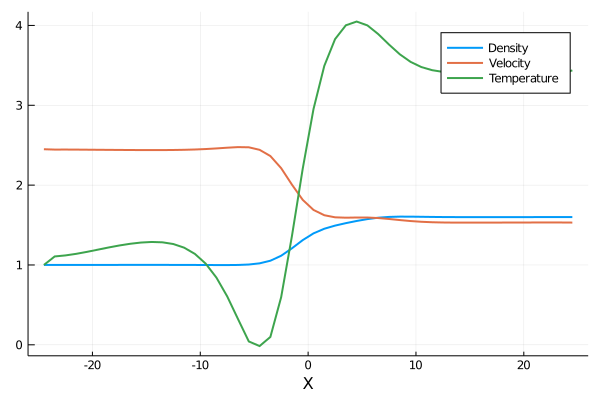

In [244]:
plot_line(ks, ctr)

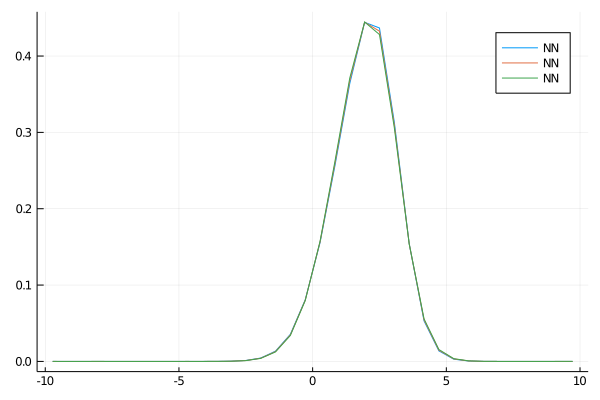

In [201]:
plot(vSpace.u, node(ctr[25].f[1:end], res.minimizer).u, label="NN")

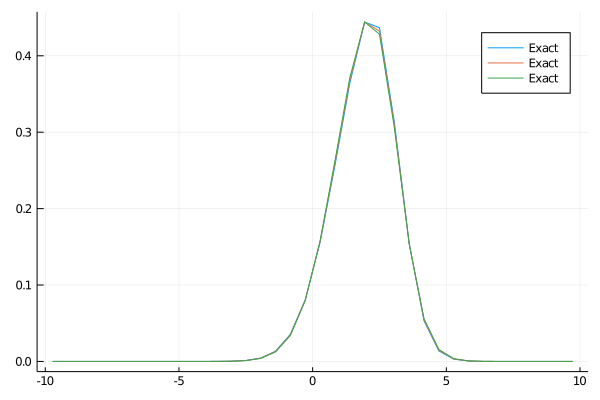

In [198]:
plot(vSpace.u, Y[:,25,:], label="Exact")

In [199]:
X

36×50 Array{Float32,2}:
 0.0          1.7299e-18   1.89053e-18  …  4.88097e-17  4.88119e-17
 0.0          5.21038e-17  5.72352e-17     1.69515e-15  1.69522e-15
 0.0          1.29123e-15  1.4266e-15      4.91952e-14  4.91972e-14
 0.0          2.62526e-14  2.91947e-14     1.19303e-12  1.19307e-12
 5.74532e-44  4.363e-13    4.88817e-13     2.41763e-11  2.41771e-11
 2.671e-39    5.899e-12    6.66586e-12  …  4.09393e-10  4.09406e-10
 6.69376e-35  6.44811e-11  7.35925e-11     5.79301e-9   5.79318e-9 
 9.04864e-31  5.65036e-10  6.52481e-10     6.84983e-8   6.85002e-8 
 6.59802e-27  3.92314e-9   4.5942e-9       6.76811e-7   6.76829e-7 
 2.59514e-23  2.12259e-8   2.52838e-8      5.58815e-6   5.58828e-6 
 5.50585e-20  8.73134e-8   1.06231e-7   …  3.8555e-5    3.85558e-5 
 6.30094e-17  2.62868e-7   3.28585e-7      0.000222282  0.000222286
 3.88959e-14  5.44241e-7   7.05038e-7      0.00107088   0.0010709  
 ⋮                                      ⋱                          
 0.146354     0.146356  